# Yeast cells detection sample notebook

This pipeline detects, segments, and tracks yeast cells in time-series microscopy data. It uses a mask-RCNN model trained on synthetic brightfield budding yeast cell data to detect and segment the cells. For tracking, the clustering algorithm DBSCAN is used with input distances based on the intersection-over-union metric. The cell (tracking) label, its centroid position, and area in pixels are extracted.

In [7]:
# %matplotlib notebook

import os
import numpy as np
import pandas as pd
import seaborn
from skimage.io import imread
from google.colab import files 
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


# Install detectron2 based on the installed version of torch,
# we assume torchvision is already installed as is the case on Google Colab.
try:
    import torch
    import detectron2
except ImportError:
    torch_version, cuda_version = torch.__version__.split('+cu')
    torch_version = '.'.join(torch_version.split('.')[:2])
    !pip3 install -U pyyaml
    !pip3 install detectron2 -f "https://dl.fbaipublicfiles.com/detectron2/wheels/cu{cuda_version}/torch{torch_version}/index.html"
    import detectron2

try:
  from download import download
except ImportError:
  !pip3 install download
  from download import download

try:
    from yeastcells import data, model, clustering, features, visualize
except ImportError:
    !test -e yeastcells-detection-maskrcnn || git clone https://github.com/ymzayek/yeastcells-detection-maskrcnn.git
    !cd yeastcells-detection-maskrcnn; git pull origin main
    !pip3 install ./yeastcells-detection-maskrcnn
    from yeastcells import data, model, clustering, features, visualize

## Download model and data

If downloading the model or data results in a time out, please try again. If the download aborts midway, also try again since downloads will continue.

This zip is only re-extracted if the folder doesn't exist or it's content is less than 500MB.

In [8]:
pipeline_path = f'/content/yeastcells-detection-maskrcnn'

download(
    'https://datascience.web.rug.nl/models/yeast-cells/mask-rcnn/v1/model_final.pth',
    f'{pipeline_path}/model_final.pth'
)

download(
    'https://datascience.web.rug.nl/YIT-Benchmark2.zip', 
    f'{pipeline_path}/YIT-Benchmark2/YIT-Benchmark2.zip'
)

# Extract the YIT-Benchmark2.zip if the folder doesn't exist or the content is
# smaller than 500MB (heuristic).
extracted_size = !du -s '{pipeline_path}/YIT-Benchmark2/'
if not os.path.exists(f'{pipeline_path}/YIT-Benchmark2/') or \
   int(''.join(extracted_size).split()[0]) < 500*1024: 
  !cd '{pipeline_path}' && unzip -o 'YIT-Benchmark2/YIT-Benchmark2.zip' -d YIT-Benchmark2
else:
  print('It seems the YIT-Benchmark2 data set is extracted alread extracted')

testset = 'TestSet1'
filenames = data.load_data(f'{pipeline_path}/YIT-Benchmark2/{testset}/RawData', ff = '.tif')

Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.
Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.
It seems the YIT-Benchmark2 data set is extracted alread extracted


## Read movie

If you have a multi stack tif file containing the time-series data you can pass that single file into fn. With individual tif files forming a time-series, you need to pass all the images to fn as in the example below.

Ensure the image is either shaped $frames \times height \times width \times 3$ or $height \times width \times 3$ for a still image. The 3 channels should be the same, and intensities should range `[0, 255]` and be of type `np.uint8`, although alternative representations might also work.



In [9]:
assert len(filenames) > 0, "No images were found"

image = [imread(filename) for filename in filenames]

assert len({im.shape for im in image}) == 1, (
    f"Images have inconsistent shapes: "
    f"{', '.join({'x'.join(map(str, im.shape)) for im in image})}")

image = np.concatenate([frame[None, ..., None] * [[[1.,1.,1.]]] for frame in image])
image = (255 * image / image.max()).astype(np.uint8)
image.shape # (frames, length, width, channels)

(60, 512, 512, 3)

## Apply Mask-RCNN model

The Mask-RCNN model segments yeast cells in each frame independently. The output is a structure where every cell is represented as an instance of bounding boxes, masks and probability scores.

For example, one can access the 13th bounding box in the 7th time frame like this.

    x0, y0, x1, y1 = np.array(output[6]['instances'].pred_boxes.tensor.to('cpu')[12])

In [10]:
predictor = model.load_model(f'{pipeline_path}/model_final.pth', seg_thresh=0.955, device='cuda:0')

In [6]:
output = [
  {'instances': predictor(frame)['instances'].to('cpu')}
  for frame in tqdm(image)
]

## Clustering detections across time frames

`coordinates` marks the centroids of each detection as $(time, x, y)$ pairs, and `labels` identifies which of them belong to the same cell over time.

To access the coordinates of the 9th cell:

    time, x, y = coordinates[labels==8].T

In [11]:
# for time-series:
labels, coordinates = clustering.cluster_cells(
    output, dmax=5, min_samples=3, eps=0.6, progress=False) 

# (dummy) for single image
# labels, coordinates = get_instance_numbers(output)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:176: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


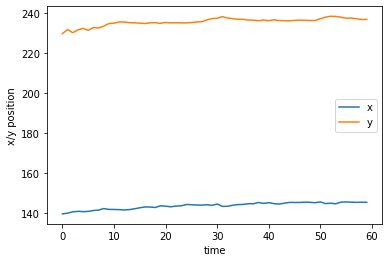

In [12]:
# Plot the x and y position of the 9th cell.

time, x, y = coordinates[labels==8].T
plt.figure()
plt.plot(time, x, label='x')
plt.plot(time, y, label='y')
plt.xlabel('time'); plt.ylabel('x/y position')
plt.legend()
None

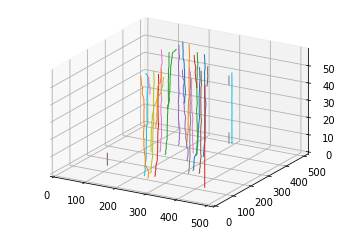

In [13]:
# plot yeast cell positions over time

ax = visualize.plot_paths(
  labels,
  coordinates[:, [2,1,0]],
  style={'linewidth': 1},
  xlim=(0, 512),
  ylim=(0, 512),
  title='',
)

## Visualize as a movie

In [14]:
# Convert the masks in output to polygons.
contours = features.extract_contours(output) 

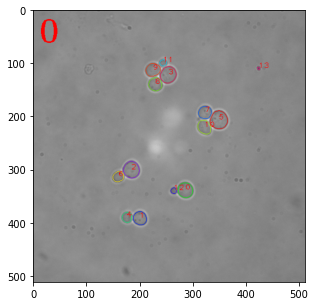

In [15]:
# Creates a colorfull stack of images, each cell is drawn as a polygon in
# the same color across frames, and can be labeled.
scene = visualize.create_scene(image, output, labels, contours, thickness=1, color=None, framenum=True, labelnum=True)

# When intereactive plotting is available, this can be animated. Otherwise
# a still image of the first frame is shown.
movie = visualize.show_animation(scene, title='', delay=700) 
#plt.axis('off')

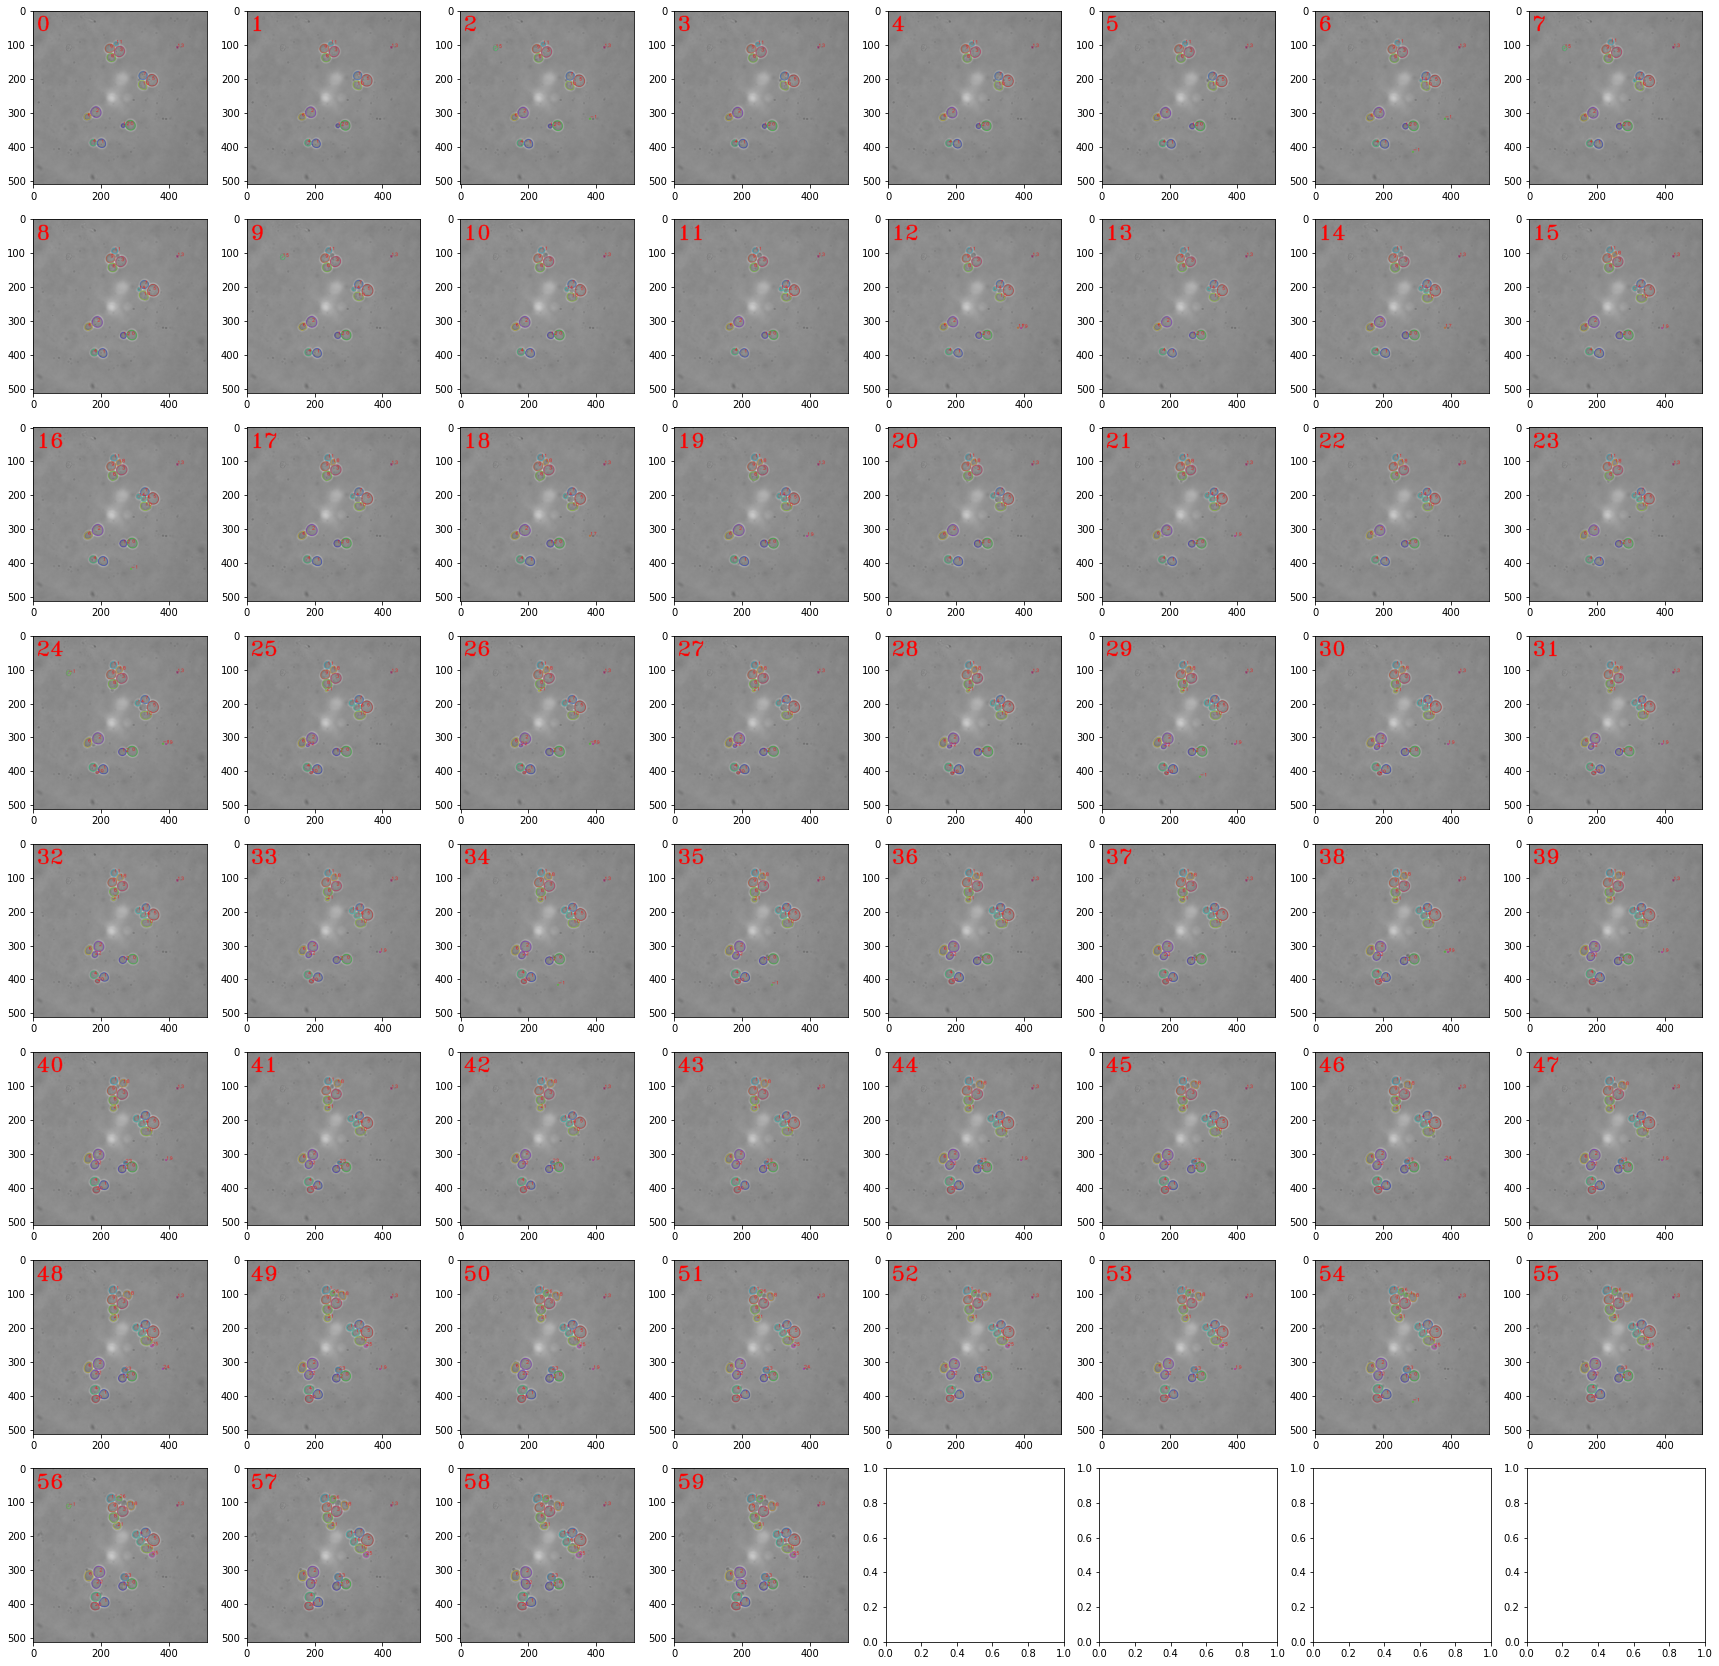

In [16]:
# Alternatively, plot every frame idependently
axes = plt.subplots(8, 8, figsize=(30, 30))[1].ravel()
for axis, frame in zip(axes, scene):
  axis.imshow(frame)

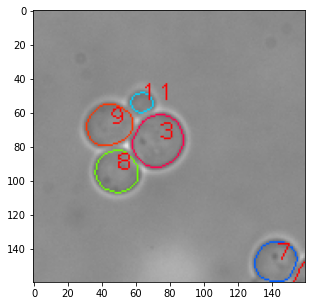

In [17]:
# One may extract the one particular cell in time and spatial dimensions
cell_scene = visualize.select_cell(scene, coordinates, labels, w=80, l=3) # choose image window (w) and label (l)
movie = visualize.show_animation(cell_scene, title='', delay=500)

## Output as a DataFrame (or spreadsheet)

This creates a dataframe with columns for time, frame number, cell number, position and the cell area. Of coruse, other features could be added when needed.

This dataframe can be exported to excel or csv spreadsheets.

In [18]:
time_interval = 3 # sampling rate in minutes per frame
masks = np.concatenate([frame['instances'].pred_masks for frame in output])
areas = masks.sum(-1).sum(-1) # sum spatial dimentions to get area

pixel_intensities = np.concatenate([
     # select pixels in the cell:
    (np.array(frame['instances'].pred_masks) * im
    ).sum(-1).sum(-1) # sum spatial dimentions to summed intensity
    for frame, im in zip(output, image[:, None, ..., 0])
])

detections = pd.DataFrame({
    'frame': coordinates[:, 0], 'time': coordinates[:, 0] * time_interval,
    'cell': labels,
    'x': coordinates[:, 2], 'y': coordinates[:, 1], # xy-order right?
    'area': areas, 'pixel intensity': pixel_intensities,
    'mean pixel intensity': pixel_intensities / areas,
})
detections

,frame,time,cell,x,y,area,pixel intensity,mean pixel intensity
0,0.0,0.0,0,286.410334,338.782675,658,84172,127.920973
1,0.0,0.0,1,200.996161,391.641075,521,67453,129.468330
2,0.0,0.0,2,184.955556,300.231373,765,100620,131.529412
3,0.0,0.0,3,254.209893,121.577540,748,99092,132.475936
4,0.0,0.0,4,176.620805,389.728188,298,37372,125.409396
...,...,...,...,...,...,...,...,...
1165,59.0,177.0,3,263.167546,126.907652,758,101478,133.875989
1166,59.0,177.0,26,252.303249,90.093863,277,36274,130.953069
1167,59.0,177.0,10,333.720395,237.129934,608,80718,132.759868
1168,59.0,177.0,9,228.451411,116.134796,319,42893,134.460815


In [19]:
try:
  from google.colab.files import download
  detections.to_excel('cell detections.xlsx')
  download('cell detections.xlsx')
except ImportError:
  print('Not on Google Colab, won\'t start download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

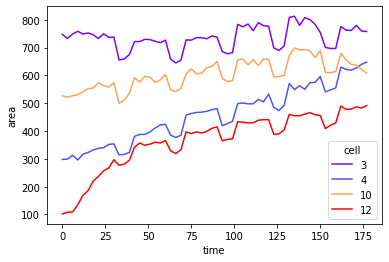

In [20]:
seaborn.lineplot(
  data = detections[detections['cell'].isin([3, 4, 12, 10])],
  x='time', hue='cell', palette='rainbow',
  y='area',
  # y='pixel intensity',
  # y='mean pixel intensity',
)

## Detection statistics

`pandas` allows finding cell statistics, for example

    # Number of tracked frames for each cell:
    detections['cell'].value_counts()

    # Number of detections:
    len(detections)

    # Detections per frame
    detections['frame'].value_counts()

Note that cells labeled with a -1 were unable to be tracked

Text(0, 0.5, 'tracked detections')

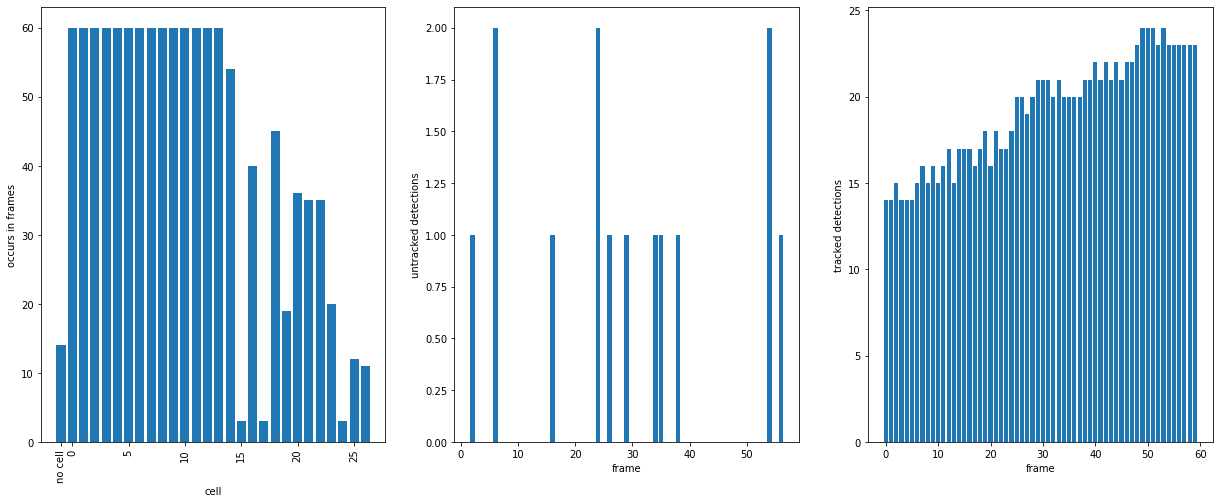

In [21]:
_, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(21, 8))

detections_per_cells = detections['cell'].value_counts()
ax0.bar(detections_per_cells.index, detections_per_cells.values)
ax0.set_xlabel('cell'); ax0.set_ylabel('occurs in frames')
ax0.set_xticks([-1, 0, 5, 10, 15, 20, 25])
ax0.set_xticklabels(['no cell', 0, 5, 10, 15, 20, 25],  rotation=90)


detections_per_frame = detections[detections['cell'] == -1]['frame'].value_counts()
ax1.bar(detections_per_frame.index, detections_per_frame.values)
ax1.set_xlabel('frame'); ax1.set_ylabel('untracked detections')

detections_per_frame = detections[detections['cell'] >= 0]['frame'].value_counts()
ax2.bar(detections_per_frame.index, detections_per_frame.values)
ax2.set_xlabel('frame'); ax2.set_ylabel('tracked detections')

## Export masks as tiff stack file


In [22]:
import tifffile
masks_out = 'masks.tif'
with tifffile.TiffWriter(masks_out) as stack:
  for m in masks:
      stack.save(m)

try:
  from google.colab.files import download
  download('masks.tif')
except ImportError:
  print('Not on Google Colab, won\'t start download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>